<a href="https://colab.research.google.com/github/redboxup/masters_thesis/blob/main/reinforcement_learning/chemotaxis/chemotaxis___.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../")
from collections import defaultdict

import itertools
import collections
from typing import Any,List,Sequence,Tuple
import tqdm
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [ ]:
#@title Environment of Windy grid
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (10, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength is zero
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 0
        winds[:,[6,7]] = 0

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [ ]:
env = WindyGridworldEnv()

In [ ]:
print(env.reset())

30


In [ ]:
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [ ]:
# Up:0; Right:1; Down:2; Left:3; 
env.step(2)
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [ ]:
#concentration field
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 10
X = np.linspace(9, 0, N)
Y = np.linspace(0, 9, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([7,9-3])
Sigma = np.array([[ 1 , 0], [0,  1]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)


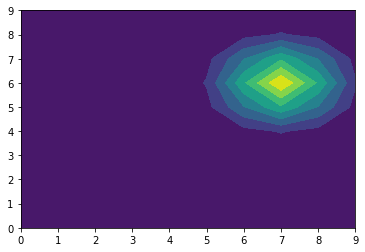

In [ ]:
#concentration field 
fig, ax = plt.subplots(1,1)
ax.contourf(X,Y,Z)

In [ ]:
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [ ]:
#policy neural network
#let us initialise parameters in a q matrix of size N_a x N_s
q = np.ones([4,70])
#let us define a function that will return z(s,a) matrices
def z(state,action):
  z_ = np.zeros([70,4])
  z_[state][action] = 1
  return z_

In [ ]:
#let us now define the h function
def h(s_i,a_j):
  z_ = z(s_i,a_j)
  h_ = q[a_j][s_i]*z_[s_i][a_j]
  return h_

In [ ]:
q[3][5] = 1
h(5,3)
np.exp(h(5,3))

2.718281828459045

In [ ]:
#now let us define the policy function
def policy(state):
  sum = 0
  p = []
  for j in range(4):
    sum += np.exp(h(state,j))
  #now probability corresponding to the action
  for j in range(4):
    p_ = np.exp(h(state,j))/sum
    p.append(p_)
  return p

In [ ]:
#code to sample an action from given probability distribution
def sample_action(state):
  prob_action = policy(state)
  action = np.random.choice(np.arange(4),p = prob_action)
  return action

In [ ]:
policy(50)

[0.25, 0.25, 0.25, 0.25]

In [ ]:
sample_action(50)

1

In [ ]:
#convert state into is feature vector
def y(s):
  s_v = np.zeros(70)
  s_v[s] = 1
  return s_v

In [ ]:
#state-value function linear approximation
def v(w,s):
  s_v = y(s)
  return np.dot(w.T,s_v)

#gradient of state-value function
def grad_v(w,s):
  s_v = y(s)
  return s_v

#let us initialise weights of the state-value function
#w = np.random.rand(70)
w = np.ones(70)

In [ ]:
#let us get some expected value
v(w,50)

1.0

In [ ]:
#main part of the code
#initialising step-size vector
alpha = 0.001
alpha_w = alpha*np.ones(np.shape(w))
alpha_q = alpha*np.ones(np.shape(q))

In [ ]:
#defining important parameters
gamma = 1

In [ ]:
#loop forever(for each episode)
def run_episode(q,w):
  #first state will be
  state = env.reset()
  is_done = False 
  I = 1
  #loop while S is not terminal for each time step
  no_step = 0
  total_reward = 0
  while is_done == False:
    #sample an action using the policy
    action = sample_action(state)
    #take the action A, observe S', R
    new_state, reward, is_done, _ = env.step(action)
    if is_done == True:
      delta = reward + gamma*0 -v(w,state)
    else:
      delta = reward + gamma*v(w,new_state) -v(w,state)
    #defining some important parameters
    r_exp = reward + v(w,new_state)
    beta = r_exp - v(w,state)
    #now we will update the weight parameters
    #using adam-algorithm we will write the standard stochastic gradient descent as
    z_times_policy = 0
    prob_action = policy(state)
    for i in range(4):
      z_times_policy += prob_action[i]*z(state,i)
    z_ = z(state,action)
    z_times_policy = z_times_policy.transpose()
    z_ = z_.transpose()
    q += alpha*beta*(z_-z_times_policy)
    w += alpha*beta*y(state)
    no_step += 1
    total_reward += reward
    #print(state,action,reward,no_step)
    state = new_state
  return no_step,total_reward

In [ ]:
#to run an episode but not update its values
def run_episode_dont_update(q,w):
  state = env.reset()
  is_done = False
  #loop while S is not terminal for each time step
  no_step = 0
  total_reward = 0
  while is_done == False:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    no_step += 1
    total_reward += reward
    state = new_state
  return no_step,total_reward

In [ ]:
steps,G = run_episode(q,w)
print(steps,G)

2380 -2380.0


In [ ]:
#let us find the mean for the model
steps, G = run_episode_dont_update(q,w)
print(steps,G)

8674 -8674.0


In [ ]:
#let us create a plot to see how the model behaves over 150 episodes
reward_tot = []
no_episodes = []
tot_episodes = 0
N = 150
for i in range(20):
  rew = 0
  for j in range(N):
    steps,rew_temp = run_episode_dont_update(q,w)
    rew += rew_temp
  rew_avg = rew/N
  reward_tot.append(rew_avg)
  no_episodes.append(tot_episodes)
  #now we will train the model for 100 episodes with updates
  for j in range(100):
    a, b = run_episode(q,w)
  tot_episodes += 100

In [ ]:
print(reward_tot)

[-5561.08, -609.4933333333333, -307.5733333333333, -247.74666666666667, -197.09333333333333, -149.84, -144.59333333333333, -116.60666666666667, -116.16666666666667, -95.24666666666667, -96.08666666666667, -92.53333333333333, -83.41333333333333, -79.54666666666667, -72.58666666666667, -68.04666666666667, -63.68, -63.43333333333333, -58.986666666666665, -56.93333333333333]


In [ ]:
print(no_episodes)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]


<Figure size 1080x720 with 0 Axes>

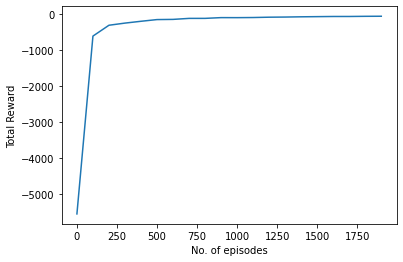

<Figure size 1080x720 with 0 Axes>

In [ ]:
#let us plot the above results
import matplotlib.pyplot as plt
plt.plot(no_episodes,reward_tot)
plt.xlabel("No. of episodes")
plt.ylabel("Total Reward")
plt.figure(figsize=(15,10))


In [ ]:
#now we want to plot all the trajectories to see what the density is like
def state2coord(state):
  a,b = divmod(state,10)
  return a,b

In [ ]:
#we ant to write a function that will give a count of each trajectory
times_visited = np.zeros([7,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  times_visited[3][0] += 1
  no_steps_this_loop = 0
  is_done = False
  while is_done == False:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

In [ ]:
av_steps = Tot_steps/50
print(av_steps)

50.68


In [ ]:
times_visited

array([[33., 31., 49., 43., 39., 34., 51., 68., 83., 84.],
       [34., 26., 38., 15., 12., 16., 38., 12., 17., 84.],
       [49., 31., 41., 13., 51., 66., 35.,  6., 16., 77.],
       [83., 46., 41., 15., 33., 43., 15., 50., 17., 77.],
       [64., 56., 57., 22., 60., 35.,  0.,  7., 53., 78.],
       [48., 51., 76., 70., 38.,  0.,  0.,  3.,  8., 32.],
       [33., 45., 52., 61.,  0.,  0.,  0.,  0.,  7., 16.]])

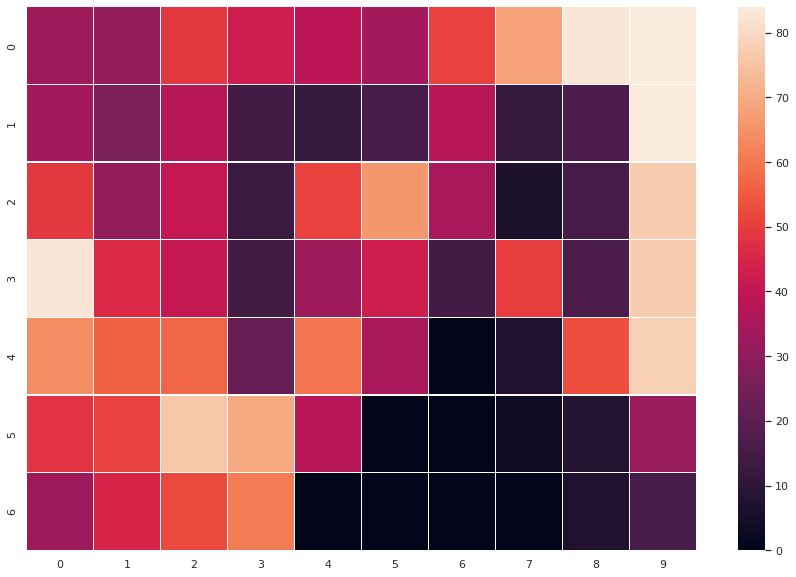

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5)

In [ ]:
#now we want to change the learning rate and retrain the model to make it better
alpha = 0.1



In [ ]:
#let us create a plot to see how the model behaves over 150 episodes
reward_tot = []
no_episodes = []
tot_episodes = 0
N = 150
for i in range(20):
  rew = 0
  for j in range(N):
    steps,rew_temp = run_episode_dont_update(q,w)
    rew += rew_temp
  rew_avg = rew/N
  reward_tot.append(rew_avg)
  no_episodes.append(tot_episodes)
  #now we will train the model for 100 episodes with updates
  for j in range(100):
    a, b = run_episode(q,w)
  tot_episodes += 100

In [ ]:
#we want to write a function that will give a count of each trajectory
times_visited = np.zeros([7,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  times_visited[3][0] += 1
  no_steps_this_loop = 0
  is_done = False
  while is_done == False:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

In [ ]:
av_steps = Tot_steps/50
print(av_steps)

16.0


In [ ]:
times_visited

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., 50., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0., 50.],
       [ 0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0., 50.],
       [50., 50., 50.,  0., 50.,  0.,  0., 50.,  0., 50.],
       [ 0.,  0., 50., 50.,  0.,  0.,  0.,  0., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

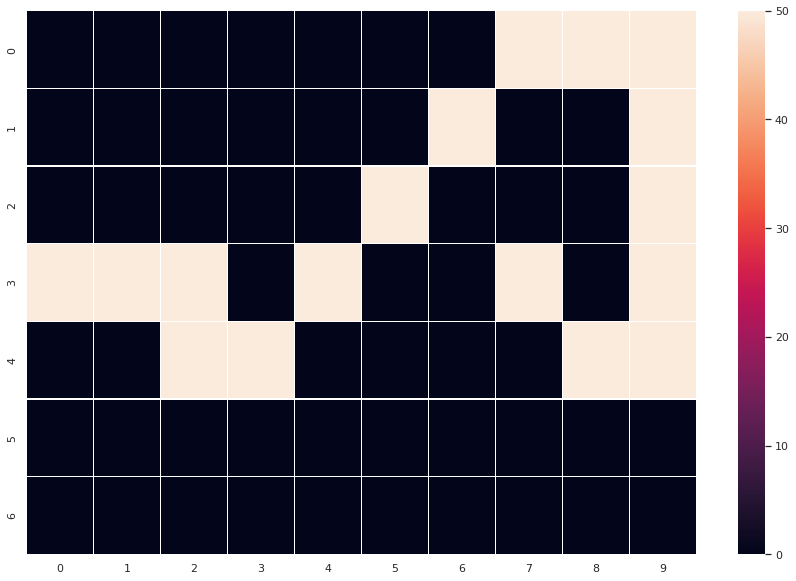

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5)

In [ ]:
#let us try to plot the value function for the grid
value_grid = np.zeros(times_visited.shape)
print(value_grid)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
for i in range(7):
  for j in range(10):
    s = i*10 +j
    value_grid[i][j] = v(w,s)

In [ ]:
v(w,50)

-18.87187313278677

In [ ]:
value_grid

array([[-1.96813236e+01, -1.99916552e+01, -1.94187938e+01,
        -1.92316361e+01, -1.38186976e+01, -9.51962673e+00,
        -8.14413872e+00, -7.00000004e+00, -6.00000000e+00,
        -5.00000000e+00],
       [-2.03259529e+01, -2.02632715e+01, -1.90459365e+01,
        -1.92364669e+01, -1.16461554e+01, -1.22036917e+01,
        -8.00009992e+00, -8.94777208e+00, -6.74700108e+00,
        -4.00000000e+00],
       [-2.04933267e+01, -2.03023885e+01, -1.71364579e+01,
        -1.44154961e+01, -1.54455239e+01, -9.00074329e+00,
        -9.22928917e+00, -6.38500429e+00, -6.81563484e+00,
        -3.00000000e+00],
       [-1.50185900e+01, -1.40189429e+01, -1.30164027e+01,
        -1.71320374e+01, -1.00027256e+01, -1.16405632e+01,
        -1.11770191e+01,  1.00000000e+00, -5.30131294e+00,
        -2.00000000e+00],
       [-1.82187868e+01, -1.37917643e+01, -1.20116855e+01,
        -1.10065651e+01, -1.42403224e+01, -1.22605880e+01,
         1.00000000e+00, -2.20361001e+00, -6.91189231e-29,
        -1.

In [ ]:
v(w,2)

-19.41879378385984

In [ ]:
np.set_printoptions(suppress=True)
value_grid

array([[-19.68132357, -19.99165518, -19.41879378, -19.23163609,
        -13.81869757,  -9.51962673,  -8.14413872,  -7.00000004,
         -6.        ,  -5.        ],
       [-20.32595287, -20.26327153, -19.0459365 , -19.23646694,
        -11.64615543, -12.20369166,  -8.00009992,  -8.94777208,
         -6.74700108,  -4.        ],
       [-20.49332666, -20.30238846, -17.13645794, -14.41549612,
        -15.44552389,  -9.00074329,  -9.22928917,  -6.38500429,
         -6.81563484,  -3.        ],
       [-15.01858999, -14.01894289, -13.01640269, -17.1320374 ,
        -10.00272561, -11.64056325, -11.17701912,   1.        ,
         -5.30131294,  -2.        ],
       [-18.21878682, -13.7917643 , -12.01168548, -11.00656511,
        -14.2403224 , -12.26058798,   1.        ,  -2.20361001,
         -0.        ,  -1.        ],
       [-18.87187313, -17.53247126, -16.52164798, -15.41927231,
        -13.2504086 ,   1.        ,   1.        ,  -0.52299854,
         -2.63103353,  -3.3818466 ],
       [-1

In [ ]:
import pandas as pd
df = pd.DataFrame(value_grid)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9
0,-19.681324,-19.991655,-19.418794,-19.231636,-13.818698,-9.519627,-8.144139,-7.000000,-6.000000e+00,-5.000000
1,-20.325953,-20.263272,-19.045937,-19.236467,-11.646155,-12.203692,-8.000100,-8.947772,-6.747001e+00,-4.000000
2,-20.493327,-20.302388,-17.136458,-14.415496,-15.445524,-9.000743,-9.229289,-6.385004,-6.815635e+00,-3.000000
3,-15.018590,-14.018943,-13.016403,-17.132037,-10.002726,-11.640563,-11.177019,1.000000,-5.301313e+00,-2.000000
4,-18.218787,-13.791764,-12.011685,-11.006565,-14.240322,-12.260588,1.000000,-2.203610,-6.911892e-29,-1.000000
5,-18.871873,-17.532471,-16.521648,-15.419272,-13.250409,1.000000,1.000000,-0.522999,-2.631034e+00,-3.381847
6,-18.145226,-16.527594,-15.377830,-14.249760,1.000000,1.000000,1.000000,1.000000,-1.237768e+00,-2.348591


[0.00019894640973936288,
 0.998190196643765,
 0.0007128843833002108,
 0.0008979725631954532]